In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [40]:
# Load datasets
train_data = pd.read_csv("train.csv") # Labeled dataset, used for training the model
test_data = pd.read_csv("test.csv") # Unlabeled dataset, will be used later for making the prediction

In [ ]:
# Import libraries needed for working with text
import re
import unidecode
# from textblob import TextBlob
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# This is needed for nltk.download(...), otherwise downloading the NLTK files return errors
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download necessary NLTK data files
nltk.download('stopwords')
# nltk.download('wordnet')
nltk.download('vader_lexicon')

import spacy 

# Load the spaCy model, which is later used for lemmatization
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

In [125]:
# Create custom dictionaries for slang words mapping

slang_dict = {
    # General abbreviations
    "u": "you",
    "r": "are",
    "ur": "your",
    "urs": "yours",
    "gr8": "great",
    "brb": "be right back",
    "btw": "by the way",
    "idk": "I don't know",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "lmk": "let me know",
    "omg": "oh my god",
    "omfg": "oh my f***ing god",
    "ttyl": "talk to you later",
    "smh": "shaking my head",
    "fyi": "for your information",
    "jk": "just kidding",
    "nvm": "never mind",
    "bc": "because",
    "pls": "please",
    "plss": "please",
    "plsss": "please",
    "plz": "please",
    "thx": "thanks",
    "k": "okay",
    "tho": "though",
    "b4": "before",
    "asap": "as soon as possible",
    "bday": "birthday",
    "g2g": "got to go",
    "atm": "at the moment",
    "grats": "congratulations",
    "congrats": "congratulations",
    "omw": "on my way",
    "sry": "sorry",
    "thru": "through",
    "ttys": "talk to you soon",
    "w/": "with",
    "w/o": "without",
    "pkwy": "parkway",
    
    # Social media abbreviations
    "fb": "Facebook",
    "ig": "Instagram",
    "yt": "YouTube",
    "dm": "direct message",
    "rt": "retweet",
    "irl": "in real life",
    "fomo": "fear of missing out",
    "tbt": "throwback Thursday",
    "lmao": "laughing my a** off",
    "lmfao": "laughing my f***ing a** off",
    "yolo": "you only live once",
    "icymi": "in case you missed it",
    "hmu": "hit me up",
    "sm": "so much",
    
    # Text message and internet slang
    "y": "why",
    "kinda": "kind of",
    "gonna": "going to",
    "wanna": "want to",
    "gotta": "got to",
    "finna": "fixing to",
    "lemme": "let me",
    "cya": "see you",
    "cu": "see you",
    "ppl": "people",
    "luv": "love",
    "bby": "baby",
    "bae": "before anyone else",
    "np": "no problem",
    "rn": "right now",
    "wyd": "what are you doing?",
    "wya": "where you at?",
    "ikr": "I know, right?",
    "fam": "family",
    "bruh": "brother",
    "sis": "sister",
    "thx": "thanks",
    "gg": "good game",
    "ez": "easy",
    "btwn": "between",
    "ftw": "for the win",
    "lit": "amazing",
    "sus": "suspicious",
    "l8r": "later",
    "2nite": "tonight",
    "tmi": "too much information",
    "jk": "just kidding",
    "oml": "oh my lord",
    "idc": "I don't care",
    "ily": "I love you",
    "ily2": "I love you too",
    
    # Numbers and shorthand phrases
    "b4n": "bye for now",
    "4u": "for you",
    "4eva": "forever",
    "2moro": "tomorrow",
    "2day": "today",
    "123": "I agree",
    "4real": "for real",
    
    # Curse words
    "wtf": "what the fuck",
    "wth": "what the hell",
    
    # Other social slang
    "rofl": "rolling on the floor laughing",
    "lol": "laughing out loud",
    "bff": "best friends forever",
    "tbh": "to be honest",
    "imo": "in my opinion",
    "imho": "in my opinion",
    "bih": "bitch",
    "stan": "super fan",
    "savage": "bold",
    "noob": "newbie",
    "goat": "greatest of all time",
    "salty": "bitter",
    "yeet": "to throw or excited",
    "slay": "succeeding",
    
    # Hashtags (optional)
    "#tbt": "throwback Thursday",
    "#fomo": "fear of missing out",
    "#yolo": "you only live once"
}

emojis_dict = {
    # Common emoji-to-text replacements
    ":)": "happy",
    ":))": "happy",
    ":)))": "happy",
    ":)))": "happy",
    ":(": "sad",
    ":((": "sad",
    ":(((": "sad",
    ":D": "laughing",
    "xD": "laughing",
    ":P": "playful",
    "<3": "love"
}

In [317]:
def remove_conflicting_rows(df, text_column, target_column):
    # Group by text column and filter for rows with conflicting targets
    conflicting_groups = df.groupby(text_column).filter(lambda x: x[target_column].nunique() > 1)
    
    # Get the indices of these conflicting rows
    conflicting_indices = conflicting_groups.index.tolist()
    
    # Drop the conflicting rows from the original DataFrame
    clean_df = df.drop(index=conflicting_indices)
    
    return clean_df, conflicting_indices

In [316]:
# Define the methods used for data cleaning

def replace_percent_20(text):
    return text.replace('%20', ' ')

def replace_slang(tweet, slang_dict): # case insensitive
    return ' '.join([slang_dict.get(word.lower(), word) for word in tweet.split()])

def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Lemmatize each token and join them back into a string
    lemmatized_words = [token.lemma_ for token in doc if token.text not in stop_words]
    return ' '.join(lemmatized_words)

def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)

    if sentiment_score['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

def clean_text(text):
    if pd.isna(text):
        return ""

    # Remove mentions (e.g., @name)
    text = re.sub(r'@\w+', '', text)

    # Remove URL links
    text = re.sub(r'http\S+|www\S+|[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)

    # Remove # and split camel case (e.g., #BigFlood -> "Big Flood")
    text = re.sub(r'#', '', text)
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

     # Remove numbers (since they don't add meaningful information)
    text = re.sub(r'\d+', '', text)

    # Remove multiple question and exclamation mark
    text = re.sub(r'(\?{2,}|\!{2,})', '', text)

    # Replace emojis
    text = replace_slang(text, emojis_dict)

    # Remove non-ASCII characters explicitly (just in case)
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Explicitly remove underscores and hyphens
    text = text.replace('_', '').replace('-', '')

    # Replace slang words
    text = replace_slang(text, slang_dict)

    # Remove diacritic
    text = unidecode.unidecode(text)

    text = text.replace('amp', ' ')

    # Correct spelling using TextBlob # Not using it now, because it is computionally time consuming
    # text = str(TextBlob(text).correct())

    # Lowercase
    text = text.lower()

    cleaned_text = lemmatize_text(text)

    return cleaned_text

def clean_and_prepare_data(df):
    clean_df = df.copy()

    # Drop location column, because it doesn't bring any information about the disaster itself
    clean_df.drop(columns=['location'], inplace=True)

    # Fill missing values with empty values and clean it
    clean_df['keyword'].fillna('', inplace=True)
    clean_df['keyword'] = clean_df['keyword'].apply(clean_text)
    clean_df['keyword'] = clean_df['keyword'].apply(replace_percent_20) #TODDO ???

    clean_df['text'] = clean_df['text'].apply(clean_text)

    # Combine 'keyword' and 'text' columns
    clean_df['combined_text'] = clean_df.apply(lambda row: f"{row['keyword']} {row['text']}", axis=1)

    # Add sentiment column, calculation of the sentiment is based on already cleaned combined_text column
    clean_df['sentiment'] = clean_df['combined_text'].apply(get_sentiment)

    return clean_df

In [318]:
clean_df, conflicting_indices = remove_conflicting_rows(train_data, 'text', 'target')

print(f"Removed {len(conflicting_indices)} conflicting rows.")

clean_train_data = clean_and_prepare_data(clean_df)
# clean_train_data = clean_and_prepare_data(train_data)

Removed 55 conflicting rows.


In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the text into numerical features using techniques like TF-IDF
# TF (Term Frequency) counts how often a word appears in a tweet.
# IDF (Inverse Document Frequency) reduces the impact of common words (like "the", "and"), giving more importance to rare, discriminative words like "flood", "earthquake", etc., which can indicate disasters.
# TfidfVectorizer is simple and doesn't require complex preprocessing compared to deep learning methods like word embeddings (e.g., Word2Vec).

vectorizer = TfidfVectorizer()
vectorized_text = vectorizer.fit_transform(clean_train_data['combined_text'])

In [323]:
# Transform sentiment to numerical values
sentiment_mapping = {
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}

clean_train_data['sentiment_encoded'] = clean_train_data['sentiment'].map(sentiment_mapping)

sentiment_encoded = np.array(clean_train_data['sentiment_encoded']).reshape(-1, 1) # reshape, so it can be used in hstack

In [177]:
from scipy.sparse import hstack

# Put together vectorized text with encoded sentiment using hstack to create feature matrix which can be later used as input to the model
X_combined = hstack([vectorized_text, sentiment_encoded])

In [178]:
X_combined.shape # here we can see that the feature matrix has 7613 rows and 12030 columns

(7558, 12010)

In [255]:
from sklearn.model_selection import train_test_split

# Define target variable
y = clean_train_data['target']

# Split the data, use stratify to get the splits with equally distributed targets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

ValueError: Found input variables with inconsistent numbers of samples: [7558, 7613]

In [180]:
X_train.shape

(6046, 12010)

In [181]:
X_test.shape

(1512, 12010)

In [182]:
# Let's try just some basic model such as Random Forest to see the evaluation metrics results

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf_random_forest = RandomForestClassifier()

clf_random_forest.fit(X_train, y_train)

y_pred_random_forest = clf_random_forest.predict(X_test)

print(classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82       863
           1       0.83      0.62      0.71       649

    accuracy                           0.78      1512
   macro avg       0.79      0.76      0.76      1512
weighted avg       0.79      0.78      0.77      1512



In [183]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion_matrix_heat_map(y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non-disaster', 'Disaster'], yticklabels=['Non-disaster', 'Disaster'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

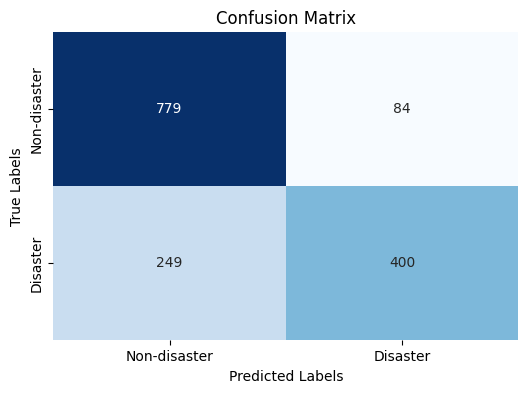

In [184]:
confusion_matrix_heat_map(y_pred_random_forest)

In [185]:
# Let's try Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_log_regression = LogisticRegression()

clf_log_regression.fit(X_train, y_train)

y_pred_log_regression = clf_log_regression.predict(X_test)

print(classification_report(y_test, y_pred_log_regression))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       863
           1       0.81      0.69      0.74       649

    accuracy                           0.80      1512
   macro avg       0.80      0.78      0.79      1512
weighted avg       0.80      0.80      0.79      1512



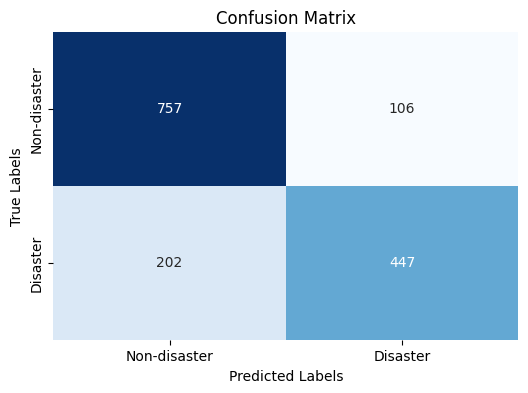

In [186]:
confusion_matrix_heat_map(y_pred_log_regression)

In [187]:
from sklearn.svm import SVC
clf_svm = SVC(kernel='rbf') 
clf_svm.fit(X_train, y_train)

y_pred_svm = clf_svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       863
           1       0.82      0.65      0.72       649

    accuracy                           0.79      1512
   macro avg       0.79      0.77      0.77      1512
weighted avg       0.79      0.79      0.78      1512



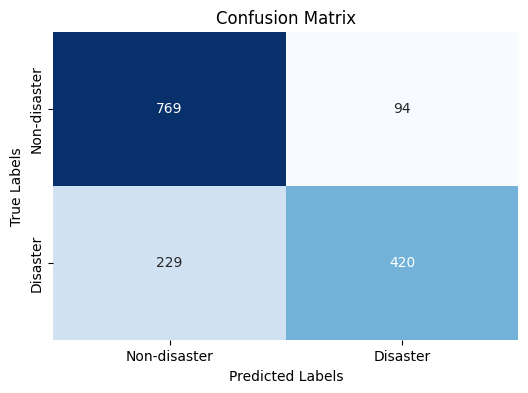

In [188]:
confusion_matrix_heat_map(y_pred_svm)

[('not', 534), ('get', 422), ('like', 390), ('fire', 370), ('go', 321), ('new', 241), ('news', 234), ('via', 220), ('people', 210), ('one', 210), ('say', 194), ('see', 186), ('video', 178), ('make', 174), ('burn', 167), ('kill', 167), ('crash', 164), ('bomb', 163), ('disaster', 159), ('time', 158), ('attack', 158), ('emergency', 157), ('come', 155), ('want', 151), ('year', 150), ('body', 149), ('day', 145), ('look', 144), ('would', 142), ('love', 139), ('police', 139), ('know', 139), ('man', 138), ('good', 138), ('take', 136), ('family', 136), ('home', 135), ('flood', 134), ('still', 129), ('building', 126), ('back', 126), ('storm', 126), ('life', 125), ('world', 125), ('watch', 124), ('think', 123), ('well', 121), ('we', 120), ('can', 120), ('california', 119), ('train', 119), ('suicide', 118), ('work', 115), ('collapse', 115), ('car', 114), ('loud', 112), ('scream', 111), ('death', 111), ('retweet', 109), ('first', 109), ('pm', 105), ('cause', 104), ('nuclear', 104), ('need', 101), (

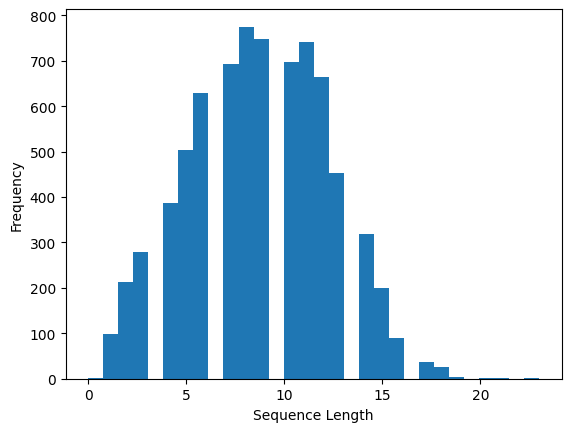

Average sequence length: 8.742524477374968
Max sequence length: 23


In [312]:
from keras.preprocessing.text import Tokenizer

# To inspect word frequency
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_data['text'])
word_counts = tokenizer.word_counts

# Sort words by frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# View the top 10 most common words
print(sorted_words[:100])

# Get the number of unique words
print(f"Total unique words: {len(word_counts)}")

sequences = tokenizer.texts_to_sequences(clean_train_data['text'])
# Get the lengths of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Plot distribution of sequence lengths
import matplotlib.pyplot as plt
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Print some statistics
print(f"Average sequence length: {np.mean(sequence_lengths)}")
print(f"Max sequence length: {np.max(sequence_lengths)}")

In [331]:
import setuptools.dist

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Example data (text and target labels)
texts = clean_train_data['combined_text']
sentiments = np.array(clean_train_data['sentiment_encoded']).reshape(-1, 1) # reshape, so it can be used in hstack
                              
labels = clean_train_data['target']

# Tokenize the text
tokenizer = Tokenizer(num_words=11967)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to ensure they have the same length
max_sequence_length = 23
X_text = pad_sequences(sequences, maxlen=max_sequence_length)
X = np.hstack((X_text, sentiments))

# Convert labels to a numpy array
y = np.array(labels)

# Split the data into training and test sets
# Split the text data (X_text), sentiment data, and labels (y)
X_text_train, X_text_test, sentiment_train, sentiment_test, y_train, y_test = train_test_split(
    X_text, sentiment_encoded, y, test_size=0.2, random_state=42, stratify=y
)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [325]:
sentiment_train

array([[-1],
       [ 0],
       [ 0],
       ...,
       [-1],
       [-1],
       [-1]])

In [374]:
from keras import Sequential
from keras import Model
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, Dropout, Input, Concatenate, BatchNormalization, Conv1D, MaxPooling1D, GlobalMaxPooling1D, concatenate
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the model
vocab_size = 11967  # Number of unique words (based on tokenizer)
embedding_dim = 100  # Size of word embedding vectors

# Define the text input
text_input = Input(shape=(max_sequence_length,), name='text_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(text_input)
lstm_layer = LSTM(32)(embedding_layer)

# Define sentiment input
sentiment_input = Input(shape=(1,), name='sentiment_input')
sentiment_dense = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01))(sentiment_input)

# Concatenate the LSTM output with sentiment
concatenated = Concatenate()([lstm_layer, sentiment_dense])
dense_layer = Dense(32, activation='relu')(concatenated)
dense_layer = Dropout(0.5)(dense_layer)
dense_layer = BatchNormalization()(dense_layer)

# Output layer (Binary classification)
output = Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model_lstm = Model(inputs=[text_input, sentiment_input], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_lstm.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 23)]                 0         []                            
                                                                                                  
 embedding_57 (Embedding)    (None, 23, 100)              1196700   ['text_input[0][0]']          
                                                                                                  
 sentiment_input (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 lstm_70 (LSTM)              (None, 32)                   17024     ['embedding_57[0][0]'] 

In [371]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model_lstm.fit(
    [X_text_train, sentiment_train],
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=([X_text_test, sentiment_test], y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
189/189 [==============================] - 3s 9ms/step - loss: 0.6921 - accuracy: 0.6047 - val_loss: 0.6501 - val_accuracy: 0.6376
Epoch 2/50
189/189 [==============================] - 1s 8ms/step - loss: 0.4374 - accuracy: 0.8339 - val_loss: 0.4970 - val_accuracy: 0.8003
Epoch 3/50
189/189 [==============================] - 2s 8ms/step - loss: 0.2962 - accuracy: 0.9011 - val_loss: 0.4927 - val_accuracy: 0.7870
Epoch 4/50
189/189 [==============================] - 2s 10ms/step - loss: 0.2077 - accuracy: 0.9390 - val_loss: 0.5980 - val_accuracy: 0.7851
Epoch 5/50
189/189 [==============================] - 2s 8ms/step - loss: 0.1703 - accuracy: 0.9522 - val_loss: 0.6528 - val_accuracy: 0.7665
Epoch 6/50
189/189 [==============================] - 2s 8ms/step - loss: 0.1370 - accuracy: 0.9648 - val_loss: 0.6998 - val_accuracy: 0.7738


In [375]:

# Input for text sequences
text_input = Input(shape=(max_sequence_length,), name='text_input')
embedded_text = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(text_input)

# CNN layers
conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedded_text)
pool1 = MaxPooling1D(pool_size=2)(conv1)

conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)

# Global max pooling to reduce dimensionality
global_pool = GlobalMaxPooling1D()(pool2)

# Input for sentiment feature
sentiment_input = Input(shape=(1,), name='sentiment_input')

# Concatenate CNN output and sentiment input
combined = concatenate([global_pool, sentiment_input])

# Dense layers after concatenation
dense_layer = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(dense_layer)

# Define the final model
model_conv = Model(inputs=[text_input, sentiment_input], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_conv.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_conv.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 23)]                 0         []                            
                                                                                                  
 embedding_58 (Embedding)    (None, 23, 100)              1196700   ['text_input[0][0]']          
                                                                                                  
 conv1d_2 (Conv1D)           (None, 19, 128)              64128     ['embedding_58[0][0]']        
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 9, 128)               0         ['conv1d_2[0][0]']            
 g1D)                                                                                      

In [376]:
# Train the model
history = model_conv.fit([X_text_train, sentiment_train], y_train,
    validation_data=([X_text_test, sentiment_test], y_test),
    epochs=10, 
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
189/189 [==============================] - 2s 8ms/step - loss: 0.5672 - accuracy: 0.7016 - val_loss: 0.4798 - val_accuracy: 0.7745
Epoch 2/10
189/189 [==============================] - 1s 7ms/step - loss: 0.3594 - accuracy: 0.8518 - val_loss: 0.4631 - val_accuracy: 0.7903
Epoch 3/10
189/189 [==============================] - 1s 6ms/step - loss: 0.2191 - accuracy: 0.9178 - val_loss: 0.6013 - val_accuracy: 0.7963
Epoch 4/10
189/189 [==============================] - 1s 6ms/step - loss: 0.1449 - accuracy: 0.9472 - val_loss: 0.6594 - val_accuracy: 0.7857
Epoch 5/10
189/189 [==============================] - 1s 6ms/step - loss: 0.1090 - accuracy: 0.9591 - val_loss: 0.7371 - val_accuracy: 0.7765
